# Lec 12. CNN - image classification

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])      # 0 ~ 1 사이로 normalization
])

test_transform = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

batch_size = 5

train_data = datasets.ImageFolder('data/squir_chip/train/', train_transform)
test_data = datasets.ImageFolder('data/squir_chip/val', test_transform)

train_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = Data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

In [4]:
print(len(train_data), len(test_data))

144 50


In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (15, 45))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

tensor([0, 1, 0, 1, 0])


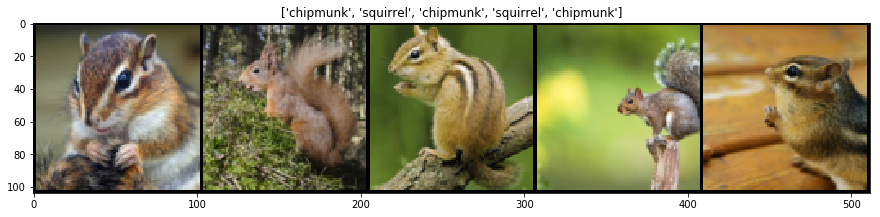

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

imshow(utils.make_grid(images, normalize=True), [train_data.classes[i] for i in labels])

## 13.2 Define Model

In [7]:
def c_conv(N, K, P=0, S=1):
    return int((N + 2*P - K) / S + 1)

def c_pool(N, K):
    return int(N/K)

In [8]:
c0 = 100
c1 = c_conv(c0, 5)
c2 = c_conv(c1, 5)
c3 = c_pool(c2, 2)

c4 = c_conv(c3, 5)
c5 = c_conv(c4, 5)
c6 = c_pool(c5, 2)

c7 = c_conv(c6, 5)
c8 = c_conv(c7, 5)
c9 = c_pool(c8, 2)

print(c1, c2, c3, c4, c5, c6, c7, c8, c9)

96 92 46 42 38 19 15 11 5


In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(3, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),            
            nn.Conv2d(16, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(),            
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, 5),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 5),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(512 * 5 * 5, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self, x):
        out = self.layer(x)
        out = out.view(-1, 512*5*5)  # fc_layer와 맞춰줄것.
        out = self.fc_layer(out)
        
        return out
    
model = CNN().cuda()

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
num_epochs = 20

total_batch = len(train_data)//batch_size

for epoch in range(num_epochs):

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pred = model(X)
        cost = loss(pred, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/20], lter [28/28] Loss: 0.2259
Epoch [2/20], lter [28/28] Loss: 5.0236
Epoch [3/20], lter [28/28] Loss: 0.3230
Epoch [4/20], lter [28/28] Loss: 1.4674
Epoch [5/20], lter [28/28] Loss: 0.0040
Epoch [6/20], lter [28/28] Loss: 0.7255
Epoch [7/20], lter [28/28] Loss: 0.1164
Epoch [8/20], lter [28/28] Loss: 0.0400
Epoch [9/20], lter [28/28] Loss: 0.0444
Epoch [10/20], lter [28/28] Loss: 1.2067
Epoch [11/20], lter [28/28] Loss: 0.0358
Epoch [12/20], lter [28/28] Loss: 0.3107
Epoch [13/20], lter [28/28] Loss: 0.1911
Epoch [14/20], lter [28/28] Loss: 0.2095
Epoch [15/20], lter [28/28] Loss: 0.2247
Epoch [16/20], lter [28/28] Loss: 0.0173
Epoch [17/20], lter [28/28] Loss: 0.0374
Epoch [18/20], lter [28/28] Loss: 0.0284
Epoch [19/20], lter [28/28] Loss: 0.1009
Epoch [20/20], lter [28/28] Loss: 0.0015


## 13.3 Test Model

In [12]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
correct = correct.cpu().numpy()    
print('correct :', correct)
print('total   :', total)
print('Accuracy of test images: %f' % (100 * correct / total))

correct : 48
total   : 50
Accuracy of test images: 96.000000


In [13]:
classes = ["Chipmunk", "Squirrel"]

Predicted:  Chipmunk Squirrel Squirrel Chipmunk Squirrel


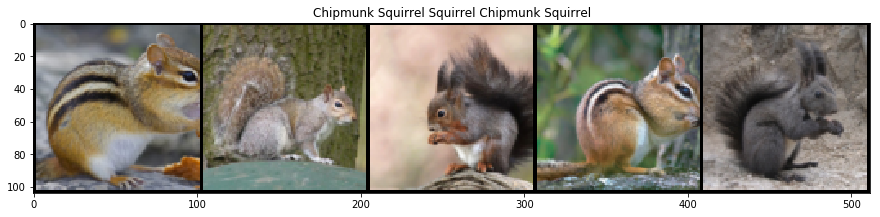

In [14]:
images, labels = iter(test_loader).next()

outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(utils.make_grid(images, normalize=True), title)

In [15]:
def imshow_one(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (2, 2))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

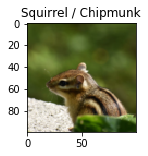

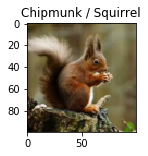

In [16]:
# 테스트 중 틀린 것만 조회

for i, (images, labels) in enumerate(test_loader) :
    
    outputs = model(images.cuda())

    _, predicted = torch.max(outputs.data, 1)

    for k in range(5):
        if predicted[k].cpu() != labels[k]:
            imshow_one(utils.make_grid(images[k], normalize=True), classes[predicted[k]] + " / " + classes[labels[k]])